Importing Modules

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

Verifying Path

In [2]:
dataset_Path = Path("data")
print(f"Checking dataset at: {dataset_Path}")
print("=" * 40)

# Check if the dataset directory structure is correct
train_image = dataset_Path / "train" / "images"
train_gt = dataset_Path / "train" / "gt"
test_image = dataset_Path / "test" / "images"

if not dataset_Path.exists():
    print(f"Dataset path {dataset_Path} does not exist.")
    print("Please ensure the dataset is correctly placed.")
    exit(1)

#Counting Files
train_img_count = len(list(train_image.glob("*.tif"))) if train_image.exists() else 0
train_gt_count = len(list(train_gt.glob("*.tif"))) if train_gt.exists() else 0
test_img_count = len(list(test_image.glob("*.tif"))) if test_image.exists() else 0

#Printing Results
print(f"Training images: {train_img_count}")
print(f"Training ground truth: {train_gt_count}")
print(f"Testing images: {test_img_count}")

if train_img_count == train_gt_count == 180:
    print("Dataset structure is correct.")
else:
    print("Dataset structure is incorrect. Please check the number of images and ground truth files.")
    



Checking dataset at: data
Training images: 180
Training ground truth: 180
Testing images: 180
Dataset structure is correct.


Exploring Single Image

In [3]:
#Loading Image and Ground Truth
img_name = "austin1.tif"
img_path = dataset_Path / "train" / "images" / img_name
gt_path = dataset_Path / "train" / "gt" / img_name

if not img_path.exists():
    print(f"Image or ground truth file does not exist at {img_path} or {gt_path}.")
    exit(1)
  
# Load using PIL  
image = Image.open(img_path)
gt = Image.open(gt_path) if gt_path.exists() else None

#Convert to numpy arrays
img_array = np.array(image)
gt_array = np.array(gt) if gt else None

#Printing Results
print(f"Image: {img_name}")
print(f"Image Shape: {img_array.shape}")
print(f"Image dtype: {img_array.dtype}")
print(f"Image min/max values: {img_array.min()}/{img_array.max()}")

if gt_array is not None:
    print(f"Ground Truth Shape: {gt_array.shape}")
    print(f"Ground truth unique values: {np.unique(gt_array)}")
    print(f"Building Pixels: {np.sum(gt_array == 255)}")
    print(f"Background Pixels: {np.sum(gt_array == 0)}")

Image: austin1.tif
Image Shape: (5000, 5000, 3)
Image dtype: uint8
Image min/max values: 0/255
Ground Truth Shape: (5000, 5000)
Ground truth unique values: [  0 255]
Building Pixels: 3688758
Background Pixels: 21311242


Visualizing Data Sample

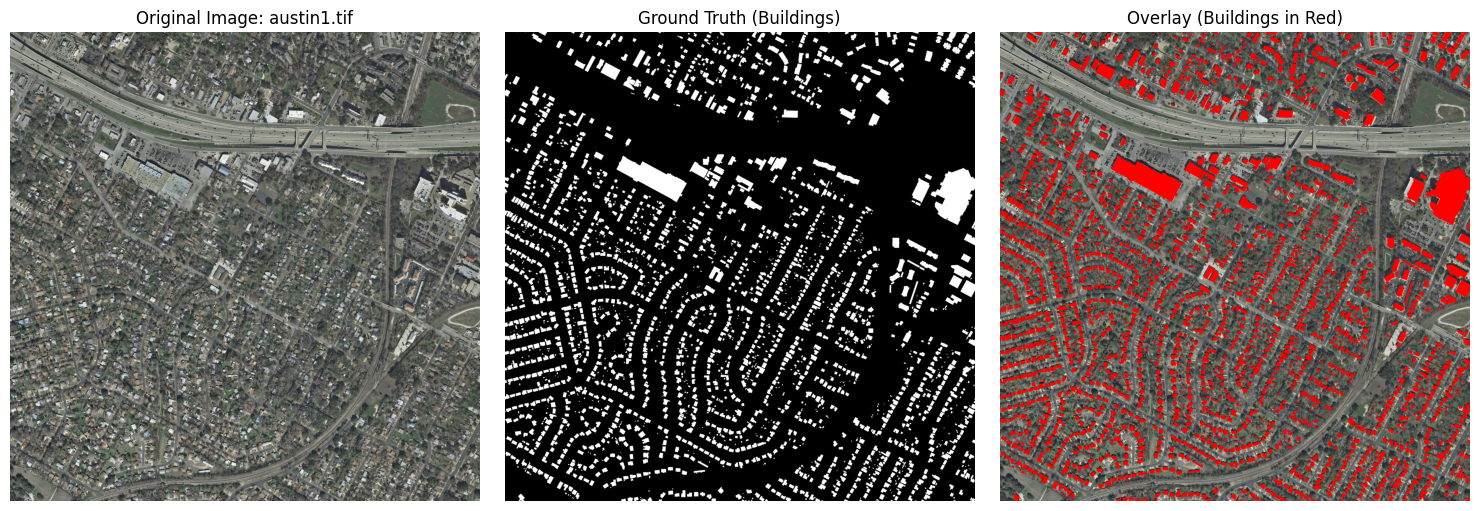

In [4]:
#creating Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#Original Image
axes[0].imshow(img_array)
axes[0].set_title(f"Original Image: {img_name}")
axes[0].axis('off')

#Ground Truth
axes[1].imshow(gt_array, cmap='gray')
axes[1].set_title(f"Ground Truth (Buildings)")
axes[1].axis('off')

#overlay
overlay = img_array.copy()
building_mask = gt_array == 255
overlay[building_mask]= [255, 0, 0] # Red color for buildings
axes[2].imshow(overlay)
axes[2].set_title(f"Overlay (Buildings in Red)")
axes[2].axis('off')

#Visual
plt.tight_layout()
plt.show()


Dataset Statistics

In [ ]:
#Initializing Variables
cities = {}
total_building_pixels = 0
total_pixels = 0

print("Dataset Statistics:")
print("=" * 30)

for img_path in train_image.glob("*.tif"):
    city_name = img_path.stem.rstrip('0123456789')
    
    if city_name not in cities:
        cities[city_name] = 0
    cities[city_name] += 1
    
    building_pixels = np.sum(gt_array == 255)
    total_building_pixels += building_pixels
    total_pixels += gt_array.size
    
#Images per city
print("Images per city:")
for city, count in cities.items():
    print(f"  {city}: {count} images")

building_ratio = total_building_pixels / total_pixels * 100
print(f"\nOVerall Building Coverage: {building_ratio:.2f}%")
print(f"Total Training Images: {len(list(train_image.glob('*.tif')))}")

Dataset Statistics:
Images per city:
  austin: 36 images
  chicago: 36 images
  kitsap: 36 images
  tyrol-w: 36 images
  vienna: 36 images

OVerall Building Coverage: 14.76%
Total Training Images: 180


Basic Image Preprocessing

In [9]:
img_normalized = img_array.astype(np.float32) / 255.0

stats = {
    'mean': np.mean(img_normalized, axis=(0, 1)),
    'std': np.std(img_normalized, axis=(0, 1)),
    'min': np.min(img_normalized, axis=(0, 1)),
    'max': np.max(img_normalized, axis=(0, 1))
}


Creating Image Patches

In [10]:
#Initializing Patch Extraction
patch_size = 512
overlap = 0.1
h, w = img_array.shape[:2]
step = int(patch_size * (1- overlap))

patches = []
positions = []

for y in range(0, h - patch_size + 1, step):
    for x in range(0, w -patch_size + 1, step):
        patch = img_array[y:y + patch_size, x:x + patch_size]
        patches.append(patch)
        positions.append((x, y))
        
print(f"Created {len(patches)} patches of size {patch_size}x{patch_size}")
print(f"Step size: {step} pixels (overlap: {overlap * 100}%)")

Created 100 patches of size 512x512
Step size: 460 pixels (overlap: 10.0%)
